# Summarize performance of classifiers
Required inputs:
* `svm_dataset_performance_metrics.txt`
* `cnn_dataset_performance_metrics.txt`

Additional inputs:
* `test_set.mat` and `test_retinopathy.mat` are used to calculate the chance lines.
* `selene_sdk.train_model.{train,validation}.txt` are training histories output by Selene. There is one file for each fold of each training batch.

Outputs:
* `modelPerformanceComparison_{cnn,svm,SiVsSE_Round3and4}.svg`: Various performance summaries of the classifiers over multiple rounds of active learning.
* `samplingComparison.svg`: Performance of the classifiers when trained with Round 3 or random sampling.
* `mutagenesisComparison.svg`: Performance of the SVM when trained with Round 1 and 2, or Round 1 and 37% of Round 3.
* `cnnClfLossCurveSummary.svg`: Training history of the CNN classifier for various rounds of learning.

In [1]:
import os
import sys

import numpy as np
from scipy import stats
import scipy.io as scio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from IPython.display import display

from src.mpra_tools import loaders, plot_utils

figures_dir = "Figures"

plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in data and aggregate together.

In [2]:
svm_dir = os.path.join(
    "ModelFitting",
    "SVM",
)
svm_df = loaders.load_data(
    os.path.join(svm_dir, "svm_dataset_performance_metrics.txt"),
)

cnn_dir = os.path.join(
    "ModelFitting",
    "CNN_Clf",
)
cnn_df = loaders.load_data(
    os.path.join(cnn_dir, "cnn_dataset_performance_metrics.txt"),
)
# Get rid of CNN Round 1, not enough data to fit
cnn_df = cnn_df.drop(index="Round1")

# Join together, then average across folds for each training data x model x test set
svm_df["model"] = "SVM"
cnn_df["model"] = "CNN"
model_df = pd.concat([svm_df, cnn_df]).replace({
    "test_set": "Mutagenesis",
    "test_retinopathy": "Genomic",
})

model_grouper = model_df.groupby(["dataset", "model", "test_set"])
model_summary_df = model_grouper[[
    "nseqs_train", "micro", "weighted", "macro", "Si", "In", "WE", "SE"
]].agg(["mean", "std"])

model_summary_df

nseqs_train               micro            \
                                         mean       std      mean       std   
dataset         model test_set                                                
GenomicOnly     CNN   Genomic          3747.0  0.000000  0.482124  0.012354   
                      Mutagenesis      3747.0  0.000000  0.349508  0.007824   
Round1          SVM   Mutagenesis      8427.9  0.316228  0.299437  0.011961   
Round2          CNN   Genomic         11823.0  0.000000  0.470575  0.028004   
                      Mutagenesis     11823.0  0.000000  0.354290  0.003598   
                SVM   Mutagenesis     12288.0  0.000000  0.293249  0.007508   
Round3a         CNN   Genomic         16199.0  0.000000  0.273883  0.014296   
                      Mutagenesis     16199.0  0.000000  0.472011  0.014514   
                SVM   Mutagenesis     16664.2  0.421637  0.359775  0.014808   
Round3aNoRound2 CNN   Genomic         12379.2  0.421637  0.270168  0.010838   
                      Mutagenesis     12379.2  0.421637  0.463854  0.012311   
                SVM   Mutagenesis     12844.2  0.421637  0.373418  0.010017   
Round3b         CNN   Genomic         23416.0  0.000000  0.288102  0.010241   
                      Mutagenesis     23416.0  0.000000  0.498594  0.016816   
                SVM   Mutagenesis     23881.4  0.516398  0.448242  0.008995   
Round3c         CNN   Genomic         17906.0  0.000000  0.234533  0.020711   
                      Mutagenesis     17906.0  0.000000  0.354571  0.020665   
                SVM   Mutagenesis     18234.7  0.483046  0.310970  0.005323   
Round4          CNN   Genomic         87904.3  0.483046  0.456820  0.030235   
                      Mutagenesis     87904.3  0.483046  0.410127  0.050625   
Round4a         CNN   Genomic         77852.0  0.000000  0.508532  0.009007   
                      Mutagenesis     77852.0  0.000000  0.316315  0.006936   
                SVM   Mutagenesis     78314.5  0.527046  0.379044  0.013959   
Round4b         CNN   Genomic         34221.1  0.316228  0.370400  0.011025   
                      Mutagenesis     34221.1  0.316228  0.505767  0.008900   
                SVM   Mutagenesis     34686.1  0.316228  0.463572  0.008418   

                                   weighted               macro            \
                                       mean       std      mean       std   
dataset         model test_set                                              
GenomicOnly     CNN   Genomic      0.336578  0.004469  0.179968  0.011554   
                      Mutagenesis  0.223643  0.027912  0.157813  0.024926   
Round1          SVM   Mutagenesis  0.251012  0.012890  0.234238  0.020868   
Round2          CNN   Genomic      0.332868  0.003268  0.183795  0.011721   
                      Mutagenesis  0.203463  0.021432  0.155113  0.030527   
                SVM   Mutagenesis  0.259535  0.011555  0.228952  0.018087   
Round3a         CNN   Genomic      0.288874  0.018244  0.252281  0.009776   
                      Mutagenesis  0.476852  0.012654  0.396072  0.016452   
                SVM   Mutagenesis  0.360741  0.018477  0.291596  0.021642   
Round3aNoRound2 CNN   Genomic      0.266123  0.012321  0.228309  0.007940   
                      Mutagenesis  0.461579  0.012875  0.357161  0.013353   
                SVM   Mutagenesis  0.360661  0.012440  0.316532  0.014802   
Round3b         CNN   Genomic      0.296644  0.009870  0.264231  0.005448   
                      Mutagenesis  0.506685  0.014640  0.412425  0.015796   
                SVM   Mutagenesis  0.457911  0.011509  0.350786  0.013894   
Round3c         CNN   Genomic      0.223673  0.028734  0.203127  0.020483   
                      Mutagenesis  0.350863  0.027993  0.283731  0.036686   
                SVM   Mutagenesis  0.291163  0.005809  0.246570  0.011649   
Round4          CNN   Genomic      0.454817  0.024108  0.368355  0.038792   
                      Mutagenesis  0.397089  0.1

Load in the test sets to create a confusion matrix for random guessing.

In [3]:
test_set_files = {
    "Mutagenesis": "test_set",
    "Genomic": "test_retinopathy",
}
chance_confusion = {}
for name, f in test_set_files.items():
    labels = scio.loadmat(os.path.join(cnn_dir, f + ".mat"))["activity_bin"].flatten()
    class_freq = pd.Series(labels).value_counts(normalize=True).sort_index()
    print(f"Class frequency for {name} data:")
    print(class_freq)
    confusion = np.outer(class_freq, [0.25, 0.25, 0.25, 0.25])
    chance_confusion[name] = confusion

Class frequency for Mutagenesis data:
0    0.036568
1    0.168776
2    0.354430
3    0.440225
dtype: float64
Class frequency for Genomic data:
0    0.280905
1    0.112594
2    0.500290
3    0.106210
dtype: float64


Helper functions for getting chance performance metrics.

In [4]:
def get_class_f1(confusion, i):
    tp = confusion[i, i]
    recall = tp / confusion[i].sum()
    precision = tp / confusion[:, i].sum()
    return 2 * (precision * recall) / (precision + recall)

def get_chance_f1(confusion, averaging):
    assert averaging == "micro" or averaging == "weighted" or averaging == "macro"
    if averaging == "micro":
        return np.diag(confusion).sum()
    else:
        classwise = [get_class_f1(confusion, i) for i in range(len(confusion))]
        if averaging == "weighted":
            return np.average(classwise, weights=confusion.sum(axis=1))
        else:
            return np.average(classwise)

Barplot of the iterative performance summary.

In [5]:
vermillion = (213/255, 94/255, 0)
blue = (0, 114/255, 178/255)
bluish_green = (0, 158/255, 115/255)
reddish_purple = (204/255, 121/255, 167/255)
sky_blue = (86/255, 180/255, 233/255)
carbon_gray = (98/255, 93/255, 93/255)
arsenic = (59/255, 68/255, 75/255)
charcoal = (54/255, 69/255, 79/255)
deep_space_sparkle = (74/255, 100/255, 108/255)
dim_gray = (105/255, 105/255, 105/255)
gray = (128/255, 128/255, 128/255)
light_gray = (211/255, 211/255, 211/255)
medium_gray= (190/255, 190/255, 190/255)
nickel = (114/255, 116/255, 114/255)

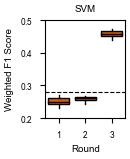

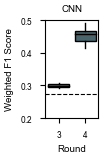

In [6]:
svm_color = vermillion
cnn_mut_color = deep_space_sparkle
cnn_gen_color = medium_gray

class_short_to_long = {
    "Si": "Silencers",
    "In": "Inactive Sequences",
    "WE": "Weak Enhancers",
    "SE": "Strong Enhancers",
}

main_display_comparison = {
    "Round1": "1",
    "Round2": "2",
    "Round3b": "3",
    "Round4": "4",
    "Round4a": "4a",
    "Round4b": "4b"
}

svm_frac = 0.15
height = 0.3 * 0.618
svm_aspect = height / svm_frac
cnn_frac = 0.1
cnn_aspect = height / cnn_frac
# cnn_aspect = svm_frac * svm_aspect / cnn_frac

def make_performance_boxplot(model, test_set, rounds, color, frac=0.3, aspect=0.618):
    df = model_df.groupby(["model", "test_set"]).get_group((model, test_set)).reset_index().pivot(
        columns = "dataset",
        index = "fold",
        values = "weighted"
    )
    fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=frac, aspect=aspect))
    bplot = ax.boxplot(
        df[rounds],
        labels = [main_display_comparison[i] for i in rounds],
        patch_artist = True,
        boxprops = {"facecolor": color},
        widths = 0.8
    )
    
    ax.axhline(
        get_chance_f1(chance_confusion[test_set], "weighted"),
        color="k",
        linestyle="--"
    )

    ax.set_ylim(0.2, 0.5)
    ax.set_xlabel("Round")
    ax.set_ylabel("Weighted F1 Score")
    ax.set_title(model)

    return fig, ax
    
fig, ax = make_performance_boxplot(
    model="SVM",
    test_set="Mutagenesis",
    rounds=["Round1", "Round2", "Round3b"],
    color=svm_color,
    frac=svm_frac,
    aspect=svm_aspect
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "modelPerformanceComparison_svm_boxplot"))

fig, ax = make_performance_boxplot(
    model="CNN",
    test_set="Genomic",
    rounds=["Round3b", "Round4"],
    color=cnn_mut_color,
    frac=cnn_frac,
    aspect=cnn_aspect
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "modelPerformanceComparison_cnn_boxplot"))

In [7]:
# svm_color = vermillion
# cnn_mut_color = deep_space_sparkle
# cnn_gen_color = medium_gray

# class_short_to_long = {
#     "Si": "Silencers",
#     "In": "Inactive Sequences",
#     "WE": "Weak Enhancers",
#     "SE": "Strong Enhancers",
# }

# main_display_comparison = {
#     "Round1": "1",
#     "Round2": "2",
#     "Round3b": "3",
#     "Round4": "4",
#     "Round4a": "4a",
#     "Round4b": "4b"
# }

# def make_performance_barplot(model, test_set, rounds, color, frac=0.3, aspect=0.618):
#     df = model_summary_df.groupby(["model", "test_set"]).get_group((model, test_set)).loc[rounds]
#     fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=frac, aspect=aspect))
#     xaxis = np.arange(len(df))
#     xticklabels = [main_display_comparison[i] for i in df.index.get_level_values("dataset").values]
#     ax.bar(
#         xaxis,
#         df["weighted", "mean"],
#         yerr=df["weighted", "std"],
#         color=color,
#         tick_label=xticklabels
#     )
    
#     ax.axhline(
#         get_chance_f1(chance_confusion[test_set], "weighted"),
#         color="k",
#         linestyle="--"
#     )

#     ax.set_ylim(0.2, 0.5)
#     ax.set_xlabel("Round")
#     ax.set_ylabel("Weighted F1 Score")
#     ax.set_title(model)

#     return fig, ax

# svm_frac = 0.15
# height = 0.3 * 0.618
# svm_aspect = height / svm_frac
# cnn_frac = 0.1
# cnn_aspect = height / cnn_frac
# # cnn_aspect = svm_frac * svm_aspect / cnn_frac

# fig, ax = make_performance_barplot(
#     model="SVM",
#     test_set="Mutagenesis",
#     rounds=["Round1", "Round2", "Round3b"],
#     color=svm_color,
#     frac=svm_frac,
#     aspect=svm_aspect
# )
# plot_utils.save_fig(fig, os.path.join(figures_dir, "modelPerformanceComparison_svm"))

# fig, ax = make_performance_barplot(
#     model="CNN",
#     test_set="Genomic",
#     rounds=["Round3b", "Round4"],
#     color=cnn_mut_color,
#     frac=cnn_frac,
#     aspect=cnn_aspect
# )
# plot_utils.save_fig(fig, os.path.join(figures_dir, "modelPerformanceComparison_cnn"))

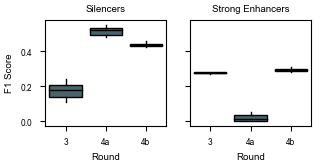

In [8]:
df = model_df.groupby(
        ["model", "test_set"]
    ).get_group(
        ("CNN", "Genomic")
    ).loc[
        ["Round3b", "Round4a", "Round4b"]
    ].reset_index(
    ).pivot(
        columns = "dataset",
        index = "fold",
        values = ["Si", "SE"]
    )

fig, ax_list = plt.subplots(ncols=2, sharey=True, figsize=plot_utils.get_figsize(frac=0.5, aspect=0.4))
ymax = 0
for ax, metric in zip(ax_list, ["Si", "SE"]):
    sub_df = df[metric]
    xticklabels = [main_display_comparison[i] for i in sub_df.columns]
    bplot = ax.boxplot(
        sub_df,
        labels = xticklabels,
        patch_artist = True,
        boxprops = {"facecolor": cnn_mut_color},
        widths = 0.8
    )
    ax.set_xlabel("Round")
    ax.set_title(class_short_to_long[metric])

ymax = max([ax.get_ylim()[1] for ax in ax_list])
for ax in ax_list:
    ax.set_ylim(ymax = ymax)

ax_list[0].set_ylabel("F1 Score")
plot_utils.save_fig(fig, os.path.join(figures_dir, "modelPerformanceComparison_SiVsSE_Round3and4_boxplot"))

Barplots comparing uncertainty sampling to random sampling.

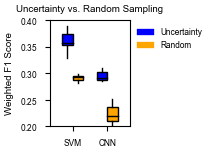

In [9]:
active_vs_random_df = model_df.loc[
    ["Round3a", "Round3c"]
].rename(index={
    "Round3a": "Uncertainty",
    "Round3c": "Random",
}).reset_index()

active_vs_random_df = active_vs_random_df[((active_vs_random_df["model"] == "SVM") & (active_vs_random_df["test_set"] == "Mutagenesis")) | ((active_vs_random_df["model"] == "CNN") & (active_vs_random_df["test_set"] == "Genomic"))]
active_vs_random_df = active_vs_random_df.pivot(
    columns = ["dataset", "model"],
    index = "fold",
    values = "weighted"
)
dataset_to_color = {
    "Uncertainty": "blue",
    "Random": "orange",
}

frac = 0.15
height = 0.28 * 0.72
fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=frac, aspect=height/frac))
x = np.array([0, 1])
width = 0.3
handles = []
for i, dataset in enumerate(dataset_to_color.keys()):
    df = active_vs_random_df[dataset]
    offset = width * i
    bplot = ax.boxplot(
        df,
        widths = width,
        positions = x + offset,
        patch_artist = True,
        boxprops = {"facecolor": dataset_to_color[dataset]}
    )
    handles.append(
        Patch(color = dataset_to_color[dataset], label = dataset)
    )
    
ticklabels = df.columns.get_level_values(level="model")

ax.set_xticks(x + width / 2, ticklabels)
ax.set_ylabel("Weighted F1 Score")
ax.legend(
    handles = handles,
    frameon=False,
    bbox_to_anchor=(1,1)
)
ax.set_title("Uncertainty vs. Random Sampling")
ax.set_ylim(bottom=0.2, top=0.4)
plot_utils.save_fig(fig, os.path.join(figures_dir, "samplingComparison_boxplot"))

Bar plot comparing 1+2 vs 1+3, using the SVM only.

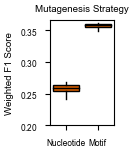

In [10]:
perturbation_comparison_df = model_df.loc[
    ["Round2", "Round3aNoRound2"]
].rename(index={
    "Round2": "Nucleotide",
    "Round3aNoRound2": "Motif"
}).reset_index()
perturbation_comparison_df = perturbation_comparison_df[(perturbation_comparison_df["model"] == "SVM")]
perturbation_comparison_df = perturbation_comparison_df.pivot(
    columns = "dataset",
    index = "fold",
    values = "weighted"
)[["Nucleotide", "Motif"]]

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=0.12, aspect=1.67))
bplot = ax.boxplot(
    perturbation_comparison_df,
    labels = perturbation_comparison_df.columns,
    widths = 0.8,
    patch_artist = True,
    boxprops = {"facecolor": svm_color}
)
ax.set_yticks(np.arange(0.2, ax.get_ylim()[1], 0.05))
ax.set_ylabel("Weighted F1 Score")
ax.set_title("Mutagenesis Strategy")
plot_utils.save_fig(fig, os.path.join(figures_dir, "mutagenesisComparison_boxplot"))

Show CNN training history.

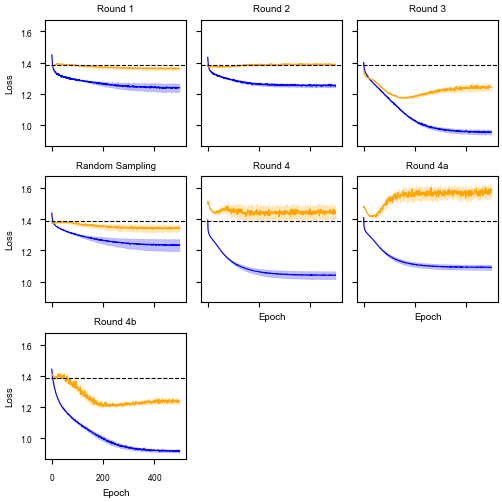

In [11]:
display_groups = {
    "Round1": "Round 1",
    "Round2": "Round 2",
    "Round3b": "Round 3",
    "Round3c": "Random Sampling",
    "Round4": "Round 4",
    "Round4a": "Round 4a",
    "Round4b": "Round 4b"
}

dataset_train_loss = dict()
dataset_val_loss = dict()
for dataset in  display_groups:
    if os.path.exists(os.path.join(cnn_dir, dataset)):
        train_loss = dict()
        val_loss = dict()
        
        for fold in range(10):
            train_loss[fold] = loaders.load_data(os.path.join(cnn_dir, dataset, str(fold + 1), "selene_sdk.train_model.train.txt"), index_col=None).squeeze()
            val_metrics = loaders.load_data(os.path.join(cnn_dir, dataset, str(fold + 1), "selene_sdk.train_model.validation.txt"), index_col=None)
            val_loss[fold] = val_metrics["loss"]
            
        train_loss = pd.DataFrame(train_loss).agg(["mean", "std"], axis=1)
        val_loss = pd.DataFrame(val_loss).agg(["mean", "std"], axis=1)                    
        dataset_train_loss[dataset] = train_loss
        dataset_val_loss[dataset] = val_loss

dataset_train_loss = pd.concat(dataset_train_loss, axis=1)
dataset_val_loss = pd.concat(dataset_val_loss, axis=1)
chance = -np.log(0.25)

ngroups = len(display_groups)
ncols = 3
nrows = int(np.ceil(ngroups / ncols))
fig, ax_list = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize=plot_utils.get_figsize(0.75, aspect=1),
)

for ax, dataset in zip(ax_list.flatten(), display_groups.keys()):
    ax.plot(
        dataset_train_loss[(dataset, "mean")],
        color="blue",
    )
    ax.fill_between(
        dataset_train_loss.index,
        dataset_train_loss[(dataset, "mean")] - dataset_train_loss[(dataset, "std")],
        dataset_train_loss[(dataset, "mean")] + dataset_train_loss[(dataset, "std")],
        color="blue",
        alpha=0.25,
    )
    ax.plot(
        dataset_val_loss[(dataset, "mean")],
        color="orange"
    )
    ax.fill_between(
        dataset_val_loss.index,
        dataset_val_loss[(dataset, "mean")] - dataset_val_loss[(dataset, "std")],
        dataset_val_loss[(dataset, "mean")] + dataset_val_loss[(dataset, "std")],
        color="orange",
        alpha=0.25,
    )
    ax.set_title(display_groups[dataset])
    ax.axhline(
        chance,
        color="k",
        linestyle="--",
    )
    
# Get rid of unused subplots, and add x labels
for i in range(ax_list.size - 1, len(display_groups) - ncols - 1, -1):
    coords = np.unravel_index(i, ax_list.shape)
    ax = ax_list[coords]
    if i >= len(display_groups):
        ax.remove()
        ax_list[coords] = None
    else:
        ax.set_xlabel("Epoch")
    
for row in range(nrows):
    ax_list[row, 0].set_ylabel("Loss")

fig.tight_layout()

plot_utils.save_fig(fig, os.path.join(figures_dir, "cnnClfLossCurveSummary"))